<a href="https://colab.research.google.com/github/Nikhil3389/Stock_prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import seaborn as sb
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [19]:
#Get the Dataset
#df=pd.read_csv('MSFT.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df=pd.read_csv('https://raw.githubusercontent.com/AakarshitChaurasia/ML_Stock_Prediction/main/MSFT.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9083.000000,9083.000000,9083.000000,9083.000000,9083.000000,9.083000e+03
mean,41.324936,41.760887,40.878488,41.335628,36.256120,5.875055e+07
std,59.696905,60.272218,59.081728,59.714567,59.981436,3.845200e+07
min,0.088542,0.092014,0.088542,0.090278,0.057046,2.304000e+06
25%,4.050781,4.102051,4.027344,4.075195,2.575089,3.461230e+07
50%,26.820000,27.100000,26.520000,26.840000,18.948530,5.203200e+07
75%,40.034999,40.443751,39.500000,39.937500,29.244812,7.265400e+07
max,344.619995,349.670013,342.200012,343.109985,342.402008,1.031789e+09


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9083 entries, 1986-03-13 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9083 non-null   float64
 1   High       9083 non-null   float64
 2   Low        9083 non-null   float64
 3   Close      9083 non-null   float64
 4   Adj Close  9083 non-null   float64
 5   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 496.7 KB


In [22]:
df.isnull().sum()
# it will print sum of null in column

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [23]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ', df.shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (9083, 6)
Null Value Present:  False


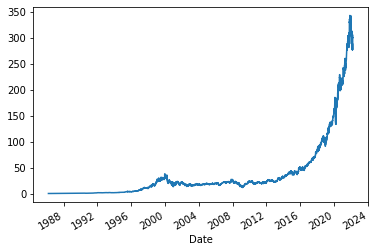

In [24]:
#Plot the True Adj Close Value
# Y axix is for stock value

df['Adj Close'].plot()

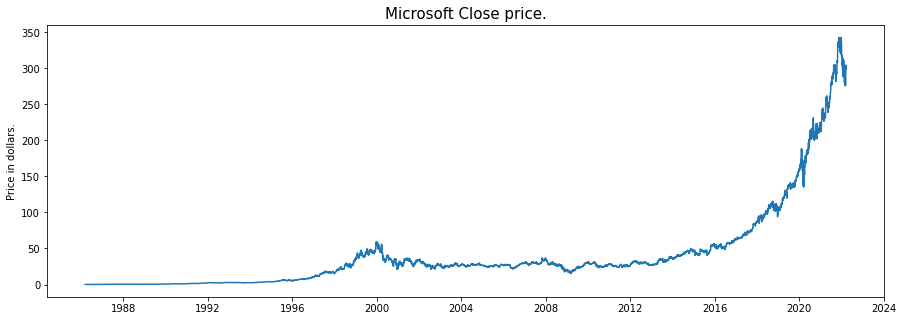

In [25]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Microsoft Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

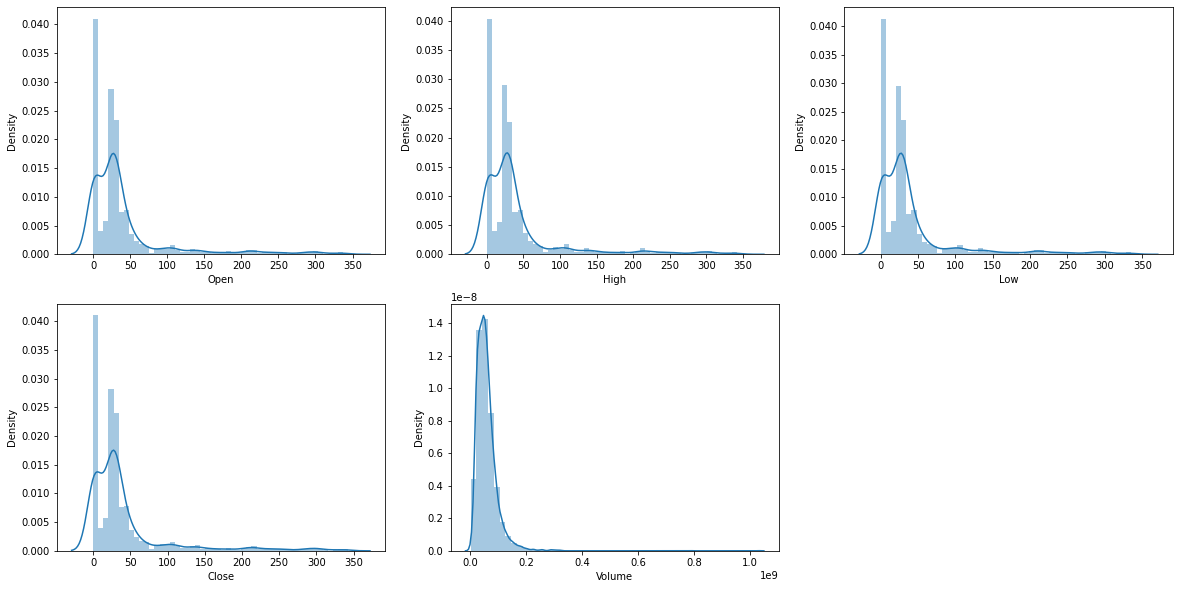

In [26]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

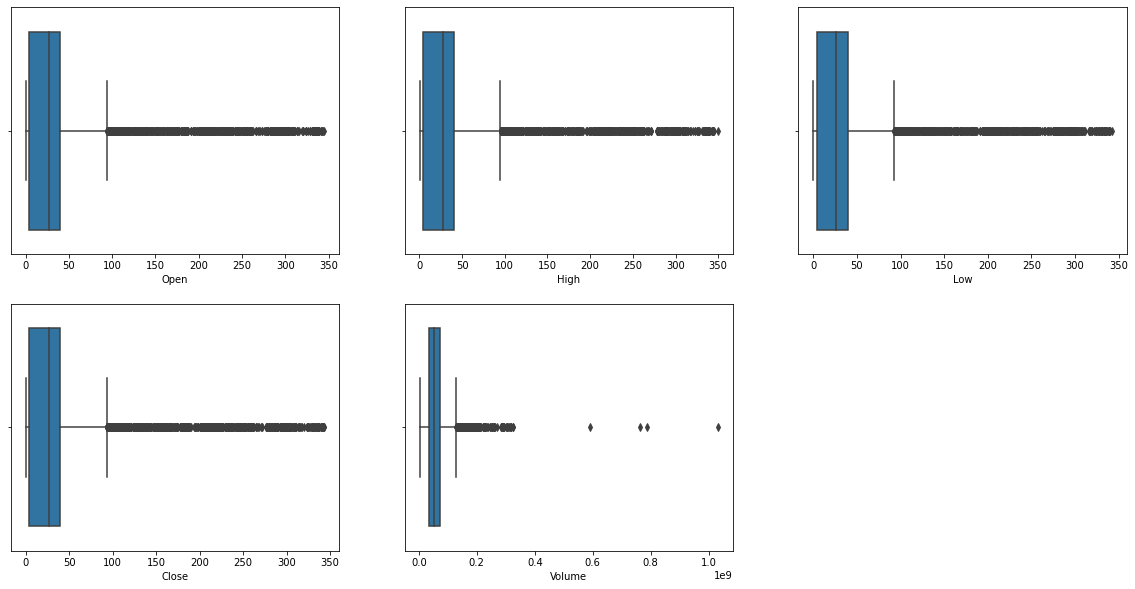

In [27]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [28]:
#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [29]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
# print(feature_transform)
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
1986-03-13,0.000000,0.000027,0.000000,1.000000
1986-03-14,0.000025,0.000030,0.000025,0.297096
1986-03-17,0.000035,0.000032,0.000036,0.127119
1986-03-18,0.000040,0.000032,0.000030,0.063588
1986-03-19,0.000033,0.000025,0.000025,0.044285


In [30]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=20)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [31]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [32]:
import pydot
import graphviz
#You must install pydot (`pip install pydot`) and install graphviz
#(see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.

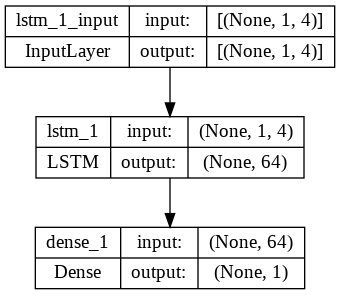

In [33]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

In [34]:
#LSTM Prediction
# mean square error

y_pred= lstm.predict(X_test)

14/14 [==============================] - 1s 2ms/step


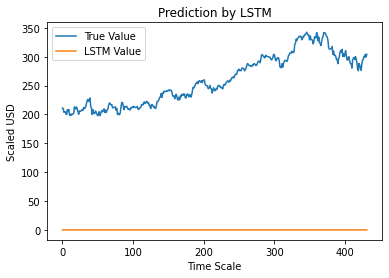

In [35]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()